In [1]:
import numpy as np
import pandas as pd
from TFT import TFT

2024-10-03 06:38:38.749988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tft = TFT(cache_data=False)

Create simulated data

In [3]:
n_days = 365
n_daily_vars = 5

df_daily = pd.DataFrame(
    np.random.randn(n_days, n_daily_vars),
    index=pd.date_range(start="2024-01-01", periods=n_days, freq="D")
)
df_daily.columns = [f"daily_var{i}" for i in range(n_daily_vars)]
df_daily

,daily_var0,daily_var1,daily_var2,daily_var3,daily_var4
2024-01-01,0.669522,0.578228,0.401572,-0.130456,0.744182
2024-01-02,0.120370,0.770970,1.242120,2.269816,0.241868
2024-01-03,-0.809623,-0.628072,-0.088475,-0.417993,-1.592156
2024-01-04,-1.077274,-0.206342,1.954736,0.434269,-0.884148
2024-01-05,-1.560374,0.069812,0.483511,-0.776529,-0.138484
...,...,...,...,...,...
2024-12-26,-1.465841,0.192307,-1.709098,1.361128,0.463109
2024-12-27,1.246829,0.504541,-0.015041,1.083913,-2.589006
2024-12-28,0.003142,0.951890,-0.405998,0.677938,2.246493
2024-12-29,0.545778,1.342194,0.383603,-2.060451,-0.391572


In [4]:
n_months = 8
n_monthly_vars = 4

df_monthly = pd.DataFrame(
    np.random.randn(n_months, n_monthly_vars),
    index=pd.date_range(start="2024-01-01", periods=n_months, freq="ME")
)
df_monthly.columns = [f"monthly_var{i}" for i in range(n_monthly_vars)]
df_monthly

,monthly_var0,monthly_var1,monthly_var2,monthly_var3
2024-01-31,0.905158,-2.489859,-1.018004,0.510050
2024-02-29,0.463544,0.663115,-0.817381,-1.249661
2024-03-31,-0.387158,-1.112540,0.071352,0.015628
2024-04-30,1.782260,1.666953,-0.022111,-1.491150
2024-05-31,0.795600,-0.756147,-0.438733,0.071518
2024-06-30,-1.314082,2.024255,0.533395,-0.468259
2024-07-31,0.695966,-1.339311,1.548778,0.989973
2024-08-31,2.373560,-0.548754,1.123345,1.428162


Now we create the dependent variable. It can be either a dataframe with two columns, or with just one column. Use the former if testing the static covarariate and everything that depends on panel data. The latter is used for simpler setting, to develop other parts of the model.

In [7]:
y_twocols = True
if y_twocols:
    y_cols = ["monthly_var0", "monthly_var1"]
    df_y = df_monthly[y_cols]
    df_monthly = df_monthly[[c for c in df_monthly if c not in y_cols]]
    df_y
else:
    df_y = df_monthly.pop("monthly_var0")
    df_y = pd.DataFrame(df_y)
    df_y

In [18]:
df_y["2024-05"]

,monthly_var0,monthly_var1
2024-01-31,0.905158,-2.489859
2024-02-29,0.463544,0.663115
2024-03-31,-0.387158,-1.112540
2024-04-30,1.782260,1.666953
2024-05-31,0.795600,-0.756147
2024-06-30,-1.314082,2.024255
2024-07-31,0.695966,-1.339311
2024-08-31,2.373560,-0.548754


In [17]:
["a", "b"] + ["c"] + []

['a', 'b', 'c']

In [10]:
tft.fit(
    X={"D": df_daily, "ME": df_monthly},
    y={"ME": df_y}
)

pred, pred_dates = tft.predict(
    X={"D": df_daily, "ME": df_monthly},
    y={"ME": df_y}
)

Processing `X` and `y` data.
  working out the frequencies...
  calculating ...
Processing `X` and `y` data: concluded
Shape of historical data: (None, 365, 8). Shape of future data: (None, None, 8)
Epoch 1/2


ValueError: Dimensions must be equal, but are 2 and 30 for '{{node compile_loss/quantile_loss/sub}} = Sub[T=DT_FLOAT](compile_loss/quantile_loss/ExpandDims, functional_1_1/concat_5)' with input shapes: [?,2,1], [?,30,3].

In [21]:
pred.shape

(214, 30, 3)

The following example shows how to put dates to the predictions, assuming the latest prediction is the one of interest.

<AxesSubplot:>

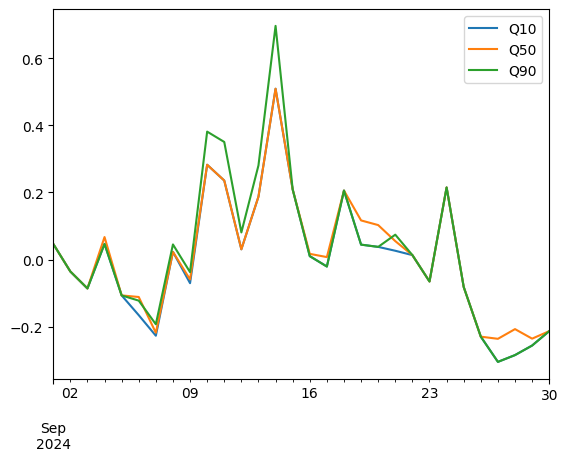

In [29]:
date_idx = pred_dates[list(pred_dates.keys())[-1]]
df_pred = pd.DataFrame(pred[-1,:,:], index=date_idx)
df_pred.columns = ["Q10", "Q50", "Q90"]
df_pred.plot()

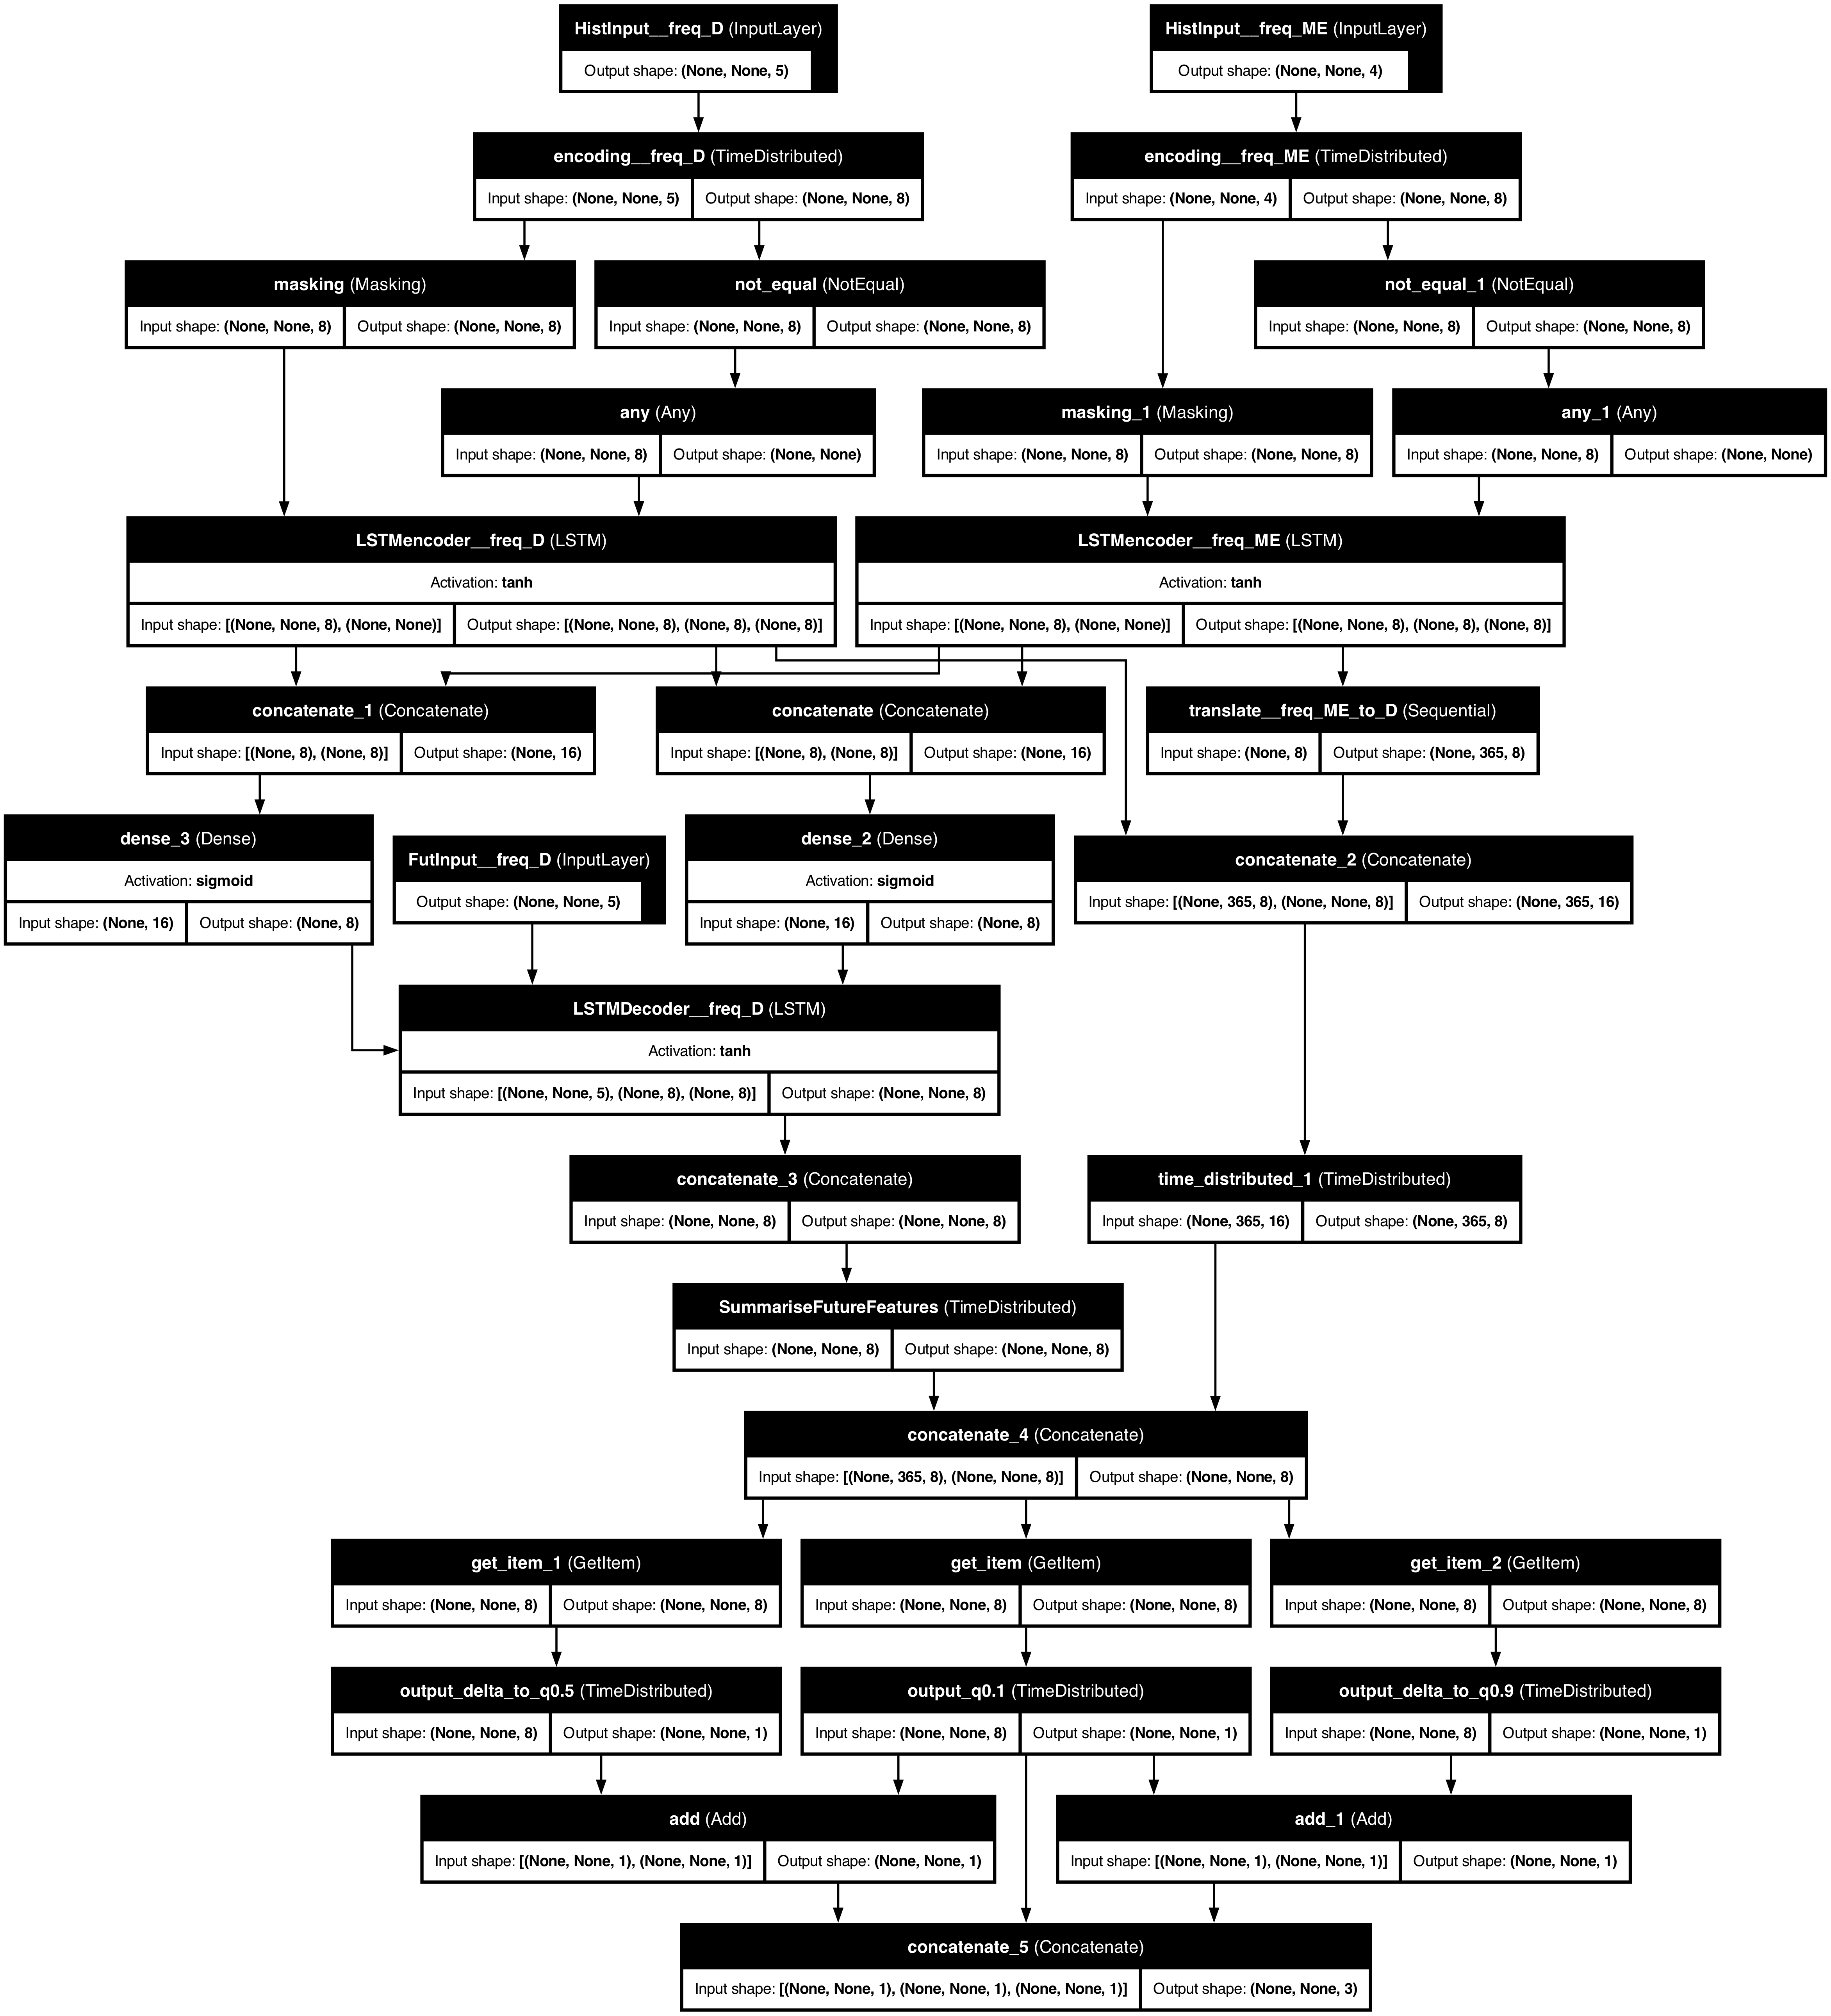

In [30]:
tft.plot_model()